## Bitsandbytes Implementation

In [1]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 9.4 MB/s eta 0:00:00:00:0100:01


In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BitsAndBytesConfig
from datasets import load_dataset
import bitsandbytes as bnb
from torch.nn import CrossEntropyLoss
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Dict, List
import gc
import logging
import os

In [ ]:
class ModelQuantizer:
    def __init__(self, model_name="gpt2"):
        self.model_name = model_name
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        
        # Base model
        self.base_model = GPT2LMHeadModel.from_pretrained(model_name)
        self.base_model.to(self.device)
        self.metrics = {"memory": {}, "latency": {}, "perplexity": {}}

    def load_dataset(self, num_samples=3000):
        dataset = load_dataset("/kaggle/input/wiki-20220301-en")        
        dataset = dataset["train"].select(range(num_samples))
        texts = [text['text'] for text in dataset]
        print(f"Total samples selected: {len(texts)}")
        if len(texts) < num_samples:
            raise ValueError(f"Only {len(texts)} samples available. Consider using a smaller 'num_samples' value.")
        
        print(f"Using {len(texts)} samples for evaluation")
        return texts

    def measure_memory(self, model) -> float:
        memory_bytes = sum(p.nelement() * p.element_size() for p in model.parameters())
        return memory_bytes / (1024 * 1024)  # Convert to MB

    def measure_latency(self, model, input_texts: list, num_runs: int = 1) -> float:
        latencies = []
        with torch.no_grad():
            for input_text in input_texts[0:10]:
                inputs = self.tokenizer(input_text[:512], return_tensors="pt").to(self.device)
                for _ in range(num_runs):
                    start_time = time.time()
                    model(**inputs)
                    latencies.append(time.time() - start_time)
        
        return sum(latencies) / len(latencies)

    def calculate_perplexity(self, model, texts: List[str], max_length: int = 512) -> float:
        total_loss = 0
        total_length = 0
        
        model.eval()
        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer(text[:max_length], return_tensors="pt").to(self.device)
                labels = inputs.input_ids
                
                outputs = model(**inputs)
                logits = outputs.logits
                
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
                
                loss_fct = CrossEntropyLoss(reduction='sum')
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)),
                              shift_labels.view(-1))
                
                total_loss += loss.item()
                total_length += labels.size(1) - 1
        
        return torch.exp(torch.tensor(total_loss / total_length)).item()

    def quantize_8bit_linear(self):
        print("Quantizing model to 8-bit linear precision...")
        quantization_config = BitsAndBytesConfig(load_in_8bit=True)
        
        model_8bit = GPT2LMHeadModel.from_pretrained(
            self.model_name,
            quantization_config=quantization_config,
            device_map="auto"
        )
        return model_8bit

    def quantize_4bit_linear(self):
        print("Quantizing model to 4-bit linear precision...")
        quantization_config = BitsAndBytesConfig(load_in_4bit=True)
        
        model_4bit_linear = GPT2LMHeadModel.from_pretrained(
            self.model_name,
            quantization_config=quantization_config,
            device_map="auto"
        )
        return model_4bit_linear

    def quantize_4bit_nf4(self):
        print("Quantizing model to 4-bit NF4 precision...")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        )
        
        model_4bit_nf4 = GPT2LMHeadModel.from_pretrained(
            self.model_name,
            quantization_config=quantization_config,
            device_map="auto"
        )
        return model_4bit_nf4

    def run_evaluation(self):
        print("Loading dataset...")
        texts = self.load_dataset()
        
        # Evaluate base model
        print("Evaluating base model...")
        memory_base = self.measure_memory(self.base_model)
        latency_base = self.measure_latency(self.base_model, texts)
        per_base = self.calculate_perplexity(self.base_model, texts)

        self.metrics["memory"]["base"] = memory_base
        self.metrics["latency"]["base"] = latency_base
        self.metrics["perplexity"]["base"] = per_base

        print("Memory (Base Model): ", memory_base)
        print("Latency (Base Model): ", latency_base)
        print("Perplexity (Base Model): ", per_base)
        
        # Clear GPU memory
        del self.base_model
        torch.cuda.empty_cache()
        gc.collect()
        
        # Evaluate 8-bit linear model
        print("Evaluating 8-bit linear model...")
        model_8bit_linear = self.quantize_8bit_linear()
        memory_8bit = self.measure_memory(model_8bit_linear)
        latency_8bit = self.measure_latency(model_8bit_linear, texts)
        perplexity_8bit = self.calculate_perplexity(model_8bit_linear, texts)

        self.metrics["memory"]["8bit_linear"] = memory_8bit
        self.metrics["latency"]["8bit_linear"] = latency_8bit
        self.metrics["perplexity"]["8bit_linear"] = perplexity_8bit

        print("Memory (8 bit Model): ", memory_8bit)
        print("Latency (8 bit Model: ", latency_8bit)
        print("Perplexity (8 bit Model: ", perplexity_8bit)
        
        del model_8bit_linear
        torch.cuda.empty_cache()
        gc.collect()
        
        # Evaluate 4-bit linear model
        print("Evaluating 4-bit linear model...")
        model_4bit_linear = self.quantize_4bit_linear()
        memory_4bit = self.measure_memory(model_4bit_linear)
        latency_4bit = self.measure_latency(model_4bit_linear, texts)
        per_4bit = self.calculate_perplexity(model_4bit_linear, texts)

        self.metrics["memory"]["4bit_linear"] = memory_4bit
        self.metrics["latency"]["4bit_linear"] = latency_4bit
        self.metrics["perplexity"]["4bit_linear"] = per_4bit

        print("Memory (4 bit Model): ", memory_4bit)
        print("Latency (4 bit Model: ", latency_4bit)
        print("Perplexity (4 bit Model: ", per_4bit)
        
        del model_4bit_linear
        torch.cuda.empty_cache()
        gc.collect()
        
        # Evaluate 4-bit NF4 model
        print("Evaluating 4-bit NF4 model...")
        model_4bit_nf4 = self.quantize_4bit_nf4()
        memory_nf4 = self.measure_memory(model_4bit_nf4)
        latency_nf4 = self.measure_latency(model_4bit_nf4, texts)
        perplexity_nf4 = self.calculate_perplexity(model_4bit_nf4, texts)

        self.metrics["memory"]["4bit_nf4"] = memory_nf4
        self.metrics["latency"]["4bit_nf4"] = latency_nf4
        self.metrics["perplexity"]["4bit_nf4"] = perplexity_nf4

        print("Memory (NF4 Model): ", memory_nf4)
        print("Latency (NF4 Model: ", latency_nf4)
        print("Perplexity (NF4 Model: ", perplexity_nf4)
        
        return self.metrics

    def plot_results(self):
        metrics = self.metrics
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        models = list(metrics["memory"].keys())
        colors = ['blue', 'green', 'red']
        
        # Memory plot
        memory_values = list(metrics["memory"].values())
        ax1.bar(models, memory_values, color=colors)
        ax1.set_title('Memory Usage (MB)')
        ax1.set_ylabel('MB')
        ax1.tick_params(axis='x', rotation=45)
        
        # Latency plot
        latency_values = list(metrics["latency"].values())
        ax2.bar(models, latency_values, color=colors)
        ax2.set_title('Inference Latency (s)')
        ax2.set_ylabel('Seconds')
        ax2.tick_params(axis='x', rotation=45)
        
        # Perplexity plot
        perplexity_values = list(metrics["perplexity"].values())
        ax3.bar(models, perplexity_values, color=colors)
        ax3.set_title('Perplexity Score')
        ax3.set_ylabel('Score')
        ax3.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('quantization_results.png')
        plt.close()

In [12]:
quantizer = ModelQuantizer()
metrics = quantizer.run_evaluation()
quantizer.plot_results()


Loading dataset...
Loading widget...
Loading widget...
Total samples selected: 3000
Using 3000 samples for evaluation
Evaluating base model...
Memory (Base Model): 474.7001953125
Latency (Base Model): 0.09513854980246875
Perplexity (Base Model): 31.616287231445312
Evaluating 8-bit linear model...
Quantizing model to 8-bit linear precision...
Memory (8-bit Model): 156.35009765625
Latency (8-bit Model): 0.05659055709838867
Perplexity (8-bit Model): 31.826826095581055
Evaluating 4-bit linear model...
Quantizing model to 4-bit linear precision...
Memory (4-bit Model): 115.85009765625
Latency (4-bit Model): 0.030150651931762695
Perplexity (4-bit Model): 35.621337890625
Evaluating 4-bit NF4 model...
Quantizing model to 4-bit NF4 precision...
Memory (NF4 Model): 115.85009765625
Latency (NF4 Model): 0.028400182723999023
Perplexity (NF4 Model): 33.94419479370117


In [ ]:
models = ["base", "8bit_linear", "4bit_linear", "4bit_nf4"]
results_by_model = {model: {} for model in models}

for category, values in metrics.items():
    for model, value in values.items():
        results_by_model[model][category] = value

print("Metrics by Model:\n")
for model, results in results_by_model.items():
    print(f"Model: {model}")
    for metric, value in results.items():
        print(f"  {metric.capitalize()}: {value}")
    print()


Metrics by Model:

Model: base
  Memory: 474.7001953125
  Latency: 0.0951385498046875
  Perplexity: 31.616287231445312

Model: 8bit_linear
  Memory: 156.35009765625
  Latency: 0.05659055709838867
  Perplexity: 31.826826095581055

Model: 4bit_linear
  Memory: 115.85009765625
  Latency: 0.030150651931762695
  Perplexity: 35.621337890625

Model: 4bit_nf4
  Memory: 115.85009765625
  Latency: 0.028400182723999023
  Perplexity: 33.94419479370117


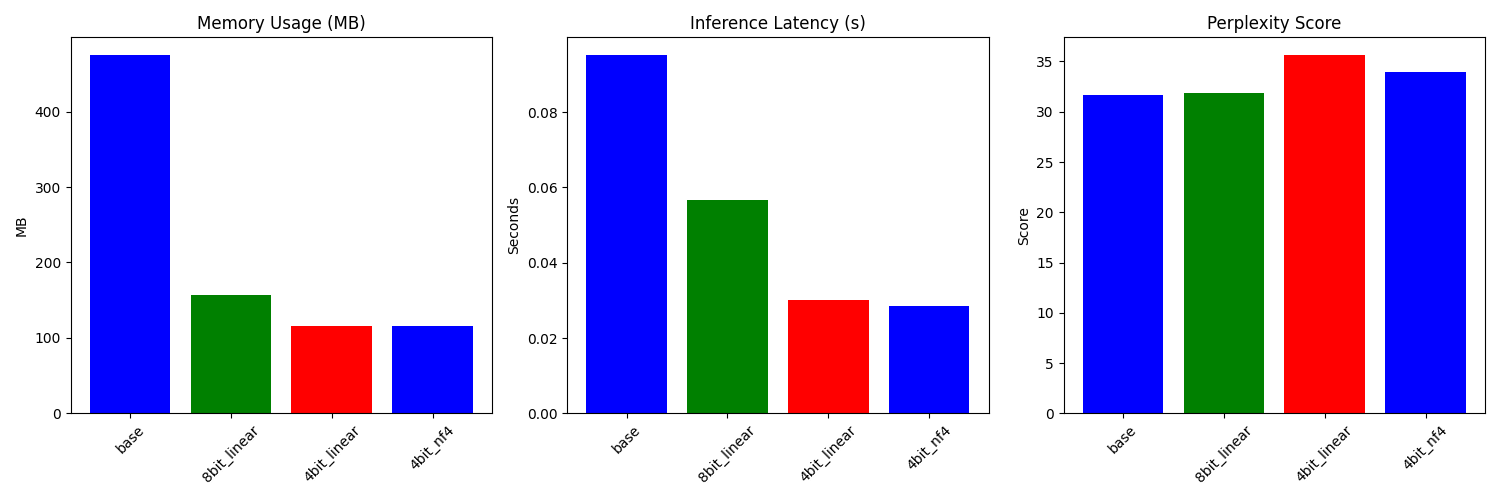

In [16]:
from IPython.display import Image, display

display(Image(filename='quantization_results.png'))